# Laboratorio: Reti Neurali con Keras

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

- Per questa esercitazione utilizziamo
  - **Keras** come API di alto livello per la costruzione e l'addestramento di reti neurali
  - **TensorFlow** come backend per la computazione da utilizzare attraverso Keras
    - usiamo l'API Keras integrata dentro a TensorFlow
- Se si lavora sul proprio PC, installare le librerie con `conda` oppure `pip`
  - su Colab sono già installate

In [1]:
# se si utilizza Anaconda:
#%conda install tensorflow

In [2]:
# altrimenti:
#%pip install tensorflow

- Importare TensorFlow per verificarne il funzionamento

In [3]:
import tensorflow as tf

2022-06-01 12:01:56.460296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 12:01:56.460315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


- Importiamo le altre librerie di uso comune

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

- Definiamo la seguente funzione di supporto per scaricare i file di dati necessari

In [5]:
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Ripasso: Reti neurali

- Una _rete neurale_ è un modello di apprendimento costituito da molteplici strati di nodi elementari
- Ciascun nodo è in pratica un modello di regressione, i cui input sono forniti dallo strato precedente e il cui output è passato a quello successivo
  - per modellare relazioni non lineari si applicano agli output dei nodi delle _funzioni di attivazione_, ad es. la funzione _ReLU_
- Tramite la _backpropagation_, i parametri (pesi e bias) di tutti i nodi sono addestrati congiuntamente per ottimizzare l'errore della rete tramite discesa gradiente stocastica
  - il training set è iterato molteplici volte (_epoche_), ad ogni iterazione le istanze vengono considerate a gruppi (_minibatch_)
- Ci sono molti aspetti configurabili (_iperparametri_) nella configurazione e nell'addestramento di una rete
  - struttura della rete: numero di strati, numero di nodi in ciascuno, funzione di attivazione, ...
  - addestramento: batch size, numero di epoche, ...

## Regressione con reti neurali

- Le reti neurali sono in primis modelli di regressione, in quanto forniscono in output un valore reale (o più d'uno)
- Vediamo un esempio concreto di uso di una rete neurale in un problema di regressione

- Riprendiamo il problema della predizione dei consumi elettrici in base alla temperatura
- Carichiamo il dataset in un frame pandas

In [6]:
download("power.csv", "https://git.io/vpaM1")
data = pd.read_csv("power.csv", index_col="date", parse_dates=["date"])

In [7]:
data.head(5)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


- Ricordiamo che anche in questo caso la relazione tra i dati è non lineare

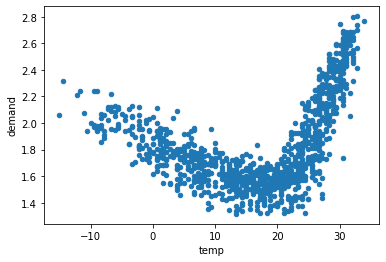

In [8]:
data.plot.scatter("temp", "demand");

- Come in precedenza consideriamo
  - i dati del 2015 e del 2016 come training set
  - quelli del 2017 come validation set
- Per ogni set estraiamo
  - le temperature registrate (variabile indipendente x)
  - i consumi (variabile dipendente y)

In [9]:
is_train = data.index.year < 2017
X_train = data.loc[is_train, ["temp"]]
y_train = data.loc[is_train, "demand"]
X_val = data.loc[~is_train, ["temp"]]
y_val = data.loc[~is_train, "demand"]

- Eseguiamo la standardizzazione sia delle X che delle y
  - non utilizziamo una pipeline per analizzare meglio i passaggi

In [10]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values[:, None]).ravel()
y_val = y_scaler.transform(y_val.values[:, None]).ravel()

- Per addestrare un modello di regressione basato su rete neurale, utilizziamo la classe `MLPRegressor`
- Questa classe supporta gli stessi iperparametri di `MLPClassifier`
- Definiamo ad esempio una rete con 4 nodi nascosti con attivazione ReLU

In [11]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(
    hidden_layer_sizes=[4],
    activation="relu",
    solver="sgd",
    random_state=12345
)

- Addestriamo il modello come al solito

In [12]:
model.fit(X_train, y_train);

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
model.score(X_val, y_val)

0.651189449215087

- Riprendiamo la funzione utilizzata in precedenza per visualizzare le predizioni del modello sovrapposte ai dati

In [14]:
def plot_model_on_data(X, y, model=None):
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (normalizzata)"); plt.ylabel("Consumi (normalizzati)")

- Usiamola per visualizzare il modello addestrato

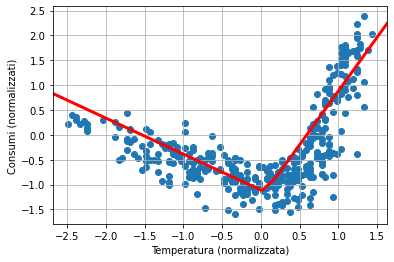

In [15]:
plot_model_on_data(X_val, y_val, model)

- Con i nodi ReLU abbiamo ottenuto in pratica una funzione "spezzata"

## Reti neurali con Keras

- Abbiamo visto il supporto basilare offerto da scikit-learn per addestrare reti neurali
- Vediamo ora come utilizzare la libreria Keras, che offre
  - maggiore configurabilità delle reti, con la possibilità di definirne nel dettaglio ciascuno strato
  - maggiore efficienza, utilizzando backend come TensorFlow con possibilità di utilizzo della GPU

## Modello di regressione con Keras

- Continuiamo a considerare il problema di predizione dei consumi, per cui ci serve un modello di regressione
- Un modello _sequenziale_ di Keras è definito da una sequenza (senza diramazioni, cicli, ecc.) di strati connessi
  - il primo strato riceve l'input dato alla rete
  - ogni strato propaga l'output allo strato successivo
  - l'ultimo strato fornisce l'output della rete
- Si definisce con un oggetto `Sequential` definendo la lista di strati
- Il tipo di strato più comune è `Dense`, in cui ogni nodo riceve input da tutti i nodi dello strato precedente

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

- Per iniziare, creiamo una "rete" con un singolo strato e un singolo nodo
- Su ogni strato `Dense` dobbiamo indicare il numero di nodi
- Inoltre sul primo strato dobbiamo indicare con `input_dim` il numero di valori in input, in questo caso due (le coordinate di ciascun punto)

In [17]:
model = Sequential([
    Dense(1, input_dim=1)
])

2022-06-01 12:01:58.954249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 12:01:58.954271: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 12:01:58.954286: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rrobby-home): /proc/driver/nvidia/version does not exist
2022-06-01 12:01:58.954464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


- L'output della rete sarà il valore restituito dal singolo nodo
  - questo è in pratica un semplice modello di regressione lineare univariata

- Col metodo `summary` vediamo un riepilogo degli strati della rete

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


- La `Output shape` indica la forma dell'output di ciascuno strato
  - il primo termine (`None`) si riferisce al numero di osservazioni in ciascun minibatch, al momento non specificato
  - il secondo termine (1) è dato dal numero di nodi specificato
- `Param #` indica il numero di parametri che saranno addestrati
  - in questo caso solamente 2: 1 peso w e 1 bias b ($y=w\cdot x+b$)

- Una volta definita la struttura della rete questa va _compilata_ per costruirne il grafo computazionale su TensorFlow
- Quando si compila la rete va specificato un algoritmo di ottimizzazione (`optimizer`) da utilizzare per addestrare la rete
  - si possono usare diverse varianti della discesa gradiente stocastica
- Va inoltre specificata la misura di errore (`loss`) da minimizzare nell'addestramento
  - per la regressione usiamo l'errore quadratico medio

In [19]:
model.compile(optimizer="adam", loss="mean_squared_error")

- Ora possiamo addestrare la rete sul training set, usando il metodo `fit` come in scikit-learn
  - passiamo la matrice X con variabili indipendenti e il vettore y con variabile dipendente da predire
- Nella discesa gradiente stocastica gli esempi di training sono presi a gruppi di dimensione pari ad una `batch_size` indicata
- L'intero training set viene scorso in ordine casuale per un numero cicli di addestramento, detti _epoche_ (`epochs`)

In [20]:
##outsnip:4:4
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=20)

Epoch 1/20
244/244 [==============================] - 0s 748us/step - loss: 0.8599
Epoch 2/20
244/244 [==============================] - 0s 782us/step - loss: 0.8587
Epoch 3/20
244/244 [==============================] - 0s 748us/step - loss: 0.8583
Epoch 4/20
244/244 [==============================] - 0s 792us/step - loss: 0.8581
Epoch 5/20
244/244 [==============================] - 0s 770us/step - loss: 0.8582
Epoch 6/20
244/244 [==============================] - 0s 740us/step - loss: 0.8585
Epoch 7/20
244/244 [==============================] - 0s 787us/step - loss: 0.8582
Epoch 8/20
244/244 [==============================] - 0s 772us/step - loss: 0.8579
Epoch 9/20
244/244 [==============================] - 0s 764us/step - loss: 0.8579
Epoch 10/20
244/244 [==============================] - 0s 774us/step - loss: 0.8582
Epoch 11/20
244/244 [==============================] - 0s 752us/step - loss: 0.8581
Epoch 12/20
244/244 [==============================] - 0s 774us/step - loss: 0.8585
E

- Durante l'addestramento, l'errore sul training set, mostrato come `loss`, si riduce progressivamente
- L'andamento di epoca in epoca viene salvato nell'oggetto `fit_history`, possiamo visualizzarlo in un grafico

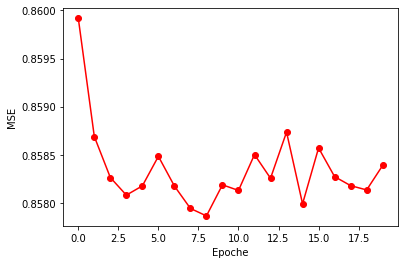

In [21]:
plt.plot(fit_history.history["loss"], "ro-")
plt.xlabel("Epoche")
plt.ylabel("MSE");

- Una volta addestrato, possiamo ottenere predizioni dal modello col metodo `predict` come in scikit-learn
- Otteniamo ad esempio le predizioni per il validation set

In [22]:
y_pred = model.predict(X_val)
y_pred[:3]

12/12 [==============================] - 0s 1ms/step


array([[-0.3513497 ],
       [-0.29646206],
       [-0.25872684]], dtype=float32)

- Si noti che i valori restituiti dal modello sono standardizzati sulla stessa scala usata nell'addestramento
- Possiamo usare il metodo `inverse_transform` del filtro per "destandardizzare" i valori riportandoli alla scala originale

In [23]:
y_scaler.inverse_transform(model.predict(X_val[:3]))

1/1 [==============================] - 0s 12ms/step


array([[1.7415233],
       [1.7603732],
       [1.7733326]], dtype=float32)

- Il metodo `evaluate` esegue una valutazione su un validation set e restituisce la misura d'errore usata in addestramento (il MSE)

In [24]:
model.evaluate(X_val, y_val)

12/12 [==============================] - 0s 855us/step - loss: 0.6909


0.6908621191978455

- Questa misura può essere confrontata tra diversi modelli
- Per ottenere una misura più generale dell'errore possiamo estrarre il coefficiente R², lo stesso restituito dal metodo `score` dei modelli di regressione di scikit-learn

In [25]:
from sklearn.metrics import r2_score
r2_score(
    y_scaler.inverse_transform(y_val[:, None]),
    y_scaler.inverse_transform(y_pred)
)

0.027853024980799668

- Data la definizione di R², otteniamo lo stesso risultato confrontando gli output standardizzati

In [26]:
r2_score(y_val, y_pred)

0.027853029177721478

- Il punteggio R² è prossimo allo 0, molto scarso
- Questo è dovuto al fatto che il modello lineare non può modellare correttamente la relazione non lineare, come mostrato dal grafico del modello

4/4 [==============================] - 0s 1ms/step


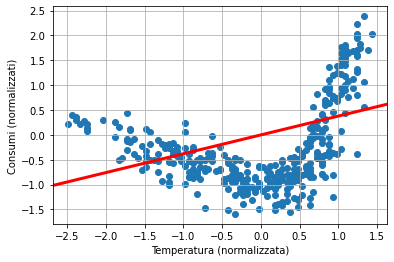

In [27]:
plot_model_on_data(X_val, y_val, model)

## Aggiungere uno strato

- Aggiungiamo ora al modello uno strato nascosto - ad es. di 8 nodi - a cui viene passato l'input
- Per introdurre non linearità, a questo strato applichiamo la funzione di attivazione ReLU
- Siano
  - $w^{(l)}_{i,j}$ il peso della connessione dal nodo $i$ dello strato $l-1$ al nodo $j$ dello strato $l$
  - $b^{(l)}_j$ il bias applicato sul nodo $j$ dello strato $l$
- Ogni nodo dello strato nascosto $i$ fornirà come output:
$$ h_i = \text{ReLU}\left(b^{(1)}_i + w^{(1)}_{1,i}\cdot x\right) $$
- A sua volta l'output sarà una combinazione di questi 16 nodi:
$$ y = b^{(2)}_1 + \sum_{i=1}^{8}{w^{(2)}_{i1}\cdot h_i} = b^{(2)}_1 + \sum_{i=1}^{8}{w^{(2)}_{i,1}\cdot\text{ReLU}\left(b^{(1)}_i + w^{(1)}_{1,i}\cdot x\right)} $$

- Creiamo un nuovo modello `Sequential` con uno strato `Dense` aggiunto con attivazione "relu"
  - lo strato in output ha sempre 1 nodo con attivazione lineare (default)

In [28]:
model = Sequential([
    Dense(8, activation="relu", input_dim=1),
    Dense(1)
])

- Eseguiamo la compilazione come sopra

In [29]:
model.compile(optimizer="adam", loss="mean_squared_error")

- Dal sommario vediamo che il modello ha 25 parametri addestrabili, ovvero
  - gli 8 pesi $w^{(1)}_{1,j}$ dati all'input ai nodi dello strato nascosto
  - gli 8 bias $b^{(1)}_j$ dei nodi dello strato nascosto
  - gli 8 pesi $w^{(2)}_{i,1}$ dati all'output dello strato nascosto dal nodo di output
  - il bias $b^{(2)}_1$ del nodo di output

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8)                 16        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


- Eseguiamo il training del modello mantenendo le stesse impostazioni

In [31]:
##outsnip:4:4
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=20)

Epoch 1/20
244/244 [==============================] - 0s 791us/step - loss: 1.4958
Epoch 2/20
244/244 [==============================] - 0s 827us/step - loss: 0.9641
Epoch 3/20
244/244 [==============================] - 0s 812us/step - loss: 0.7119
Epoch 4/20
244/244 [==============================] - 0s 823us/step - loss: 0.5586
Epoch 5/20
244/244 [==============================] - 0s 804us/step - loss: 0.4536
Epoch 6/20
244/244 [==============================] - 0s 793us/step - loss: 0.3793
Epoch 7/20
244/244 [==============================] - 0s 801us/step - loss: 0.3290
Epoch 8/20
244/244 [==============================] - 0s 818us/step - loss: 0.2921
Epoch 9/20
244/244 [==============================] - 0s 853us/step - loss: 0.2685
Epoch 10/20
244/244 [==============================] - 0s 802us/step - loss: 0.2507
Epoch 11/20
244/244 [==============================] - 0s 828us/step - loss: 0.2372
Epoch 12/20
244/244 [==============================] - 0s 813us/step - loss: 0.2275
E

- Vediamo già durante il training che la _loss_ (il MSE sul training set) è scesa di più rispetto alla rete precedente

- Grafichiamo come sopra l'andamento del MSE durante il training

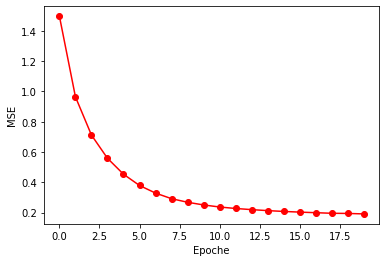

In [32]:
plt.plot(fit_history.history["loss"], "ro-")
plt.xlabel("Epoche")
plt.ylabel("MSE");

- Calcoliamo MSE e R² sul validation set

In [33]:
model.evaluate(X_val, y_val)

12/12 [==============================] - 0s 829us/step - loss: 0.2255


0.22554846107959747

In [34]:
r2_score(y_val, model.predict(X_val))

12/12 [==============================] - 0s 753us/step


0.6826193848536843

- Grazie alla combinazione di nodi non lineari abbiamo ottenuto un modello nettamente migliore, come visibile anche dal grafico

4/4 [==============================] - 0s 1ms/step


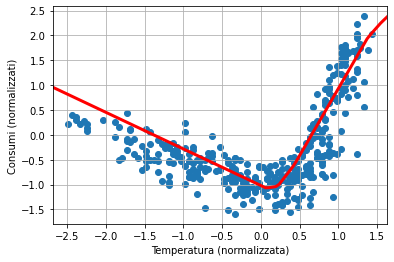

In [35]:
plot_model_on_data(X_val, y_val, model)

- Col metodo `get_weights` possiamo ottenere i parametri del modello, scomposti in questo caso in
  - una matrice 1x8 con i pesi dello strato nascosto
  - un vettore con gli 8 bias dello strato nascosto
  - una matrice 8x1 con i pesi del nodo di output
  - un vettore con il bias del nodo di output

In [36]:
model.get_weights()

[array([[-0.8191607 ,  0.20476808,  1.140861  ,  0.08004726, -0.4655723 ,
         -0.727894  ,  0.26060814, -0.63253784]], dtype=float32),
 array([ 0.0569277 , -0.31781298, -0.24624728, -0.12425224,  0.64276856,
         0.31200847, -0.40159246,  0.87152046], dtype=float32),
 array([[ 1.2075187 ],
        [-0.5042149 ],
        [ 1.5401789 ],
        [-0.6972863 ],
        [-0.9663397 ],
        [ 0.9430387 ],
        [-0.41315553],
        [-0.7739441 ]], dtype=float32),
 array([-0.08722863], dtype=float32)]

## Esercizio 1: Regressione in Keras

- **(1a)** Definire, addestrare e calcolare R² di un modello a rete neurale come quello sopra ma con 32 nodi nello strato nascosto invece di 8
- **(1b)** Definire, addestrare e calcolare R² di un modello a rete neurale con due strati nascosti rispettivamente di 32 e 8 nodi, entrambi con attivazione ReLU
- Quesito: quanti parametri addestrabili ha ciascuno di questi due modelli? (rispondere prima di utilizzare `summary`)

In [37]:
##solhead:ESERCIZIO 1

In [38]:
##sol:1a (1*32 + 32 + 32*1 + 1 = 97 parametri)
model = Sequential([
    Dense(32, activation="relu", input_dim=1),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, batch_size=3, epochs=10)
r2_score(y_val, model.predict(X_val))

Epoch 1/10
244/244 [==============================] - 0s 783us/step - loss: 0.8413
Epoch 2/10
244/244 [==============================] - 0s 777us/step - loss: 0.5126
Epoch 3/10
244/244 [==============================] - 0s 817us/step - loss: 0.3515
Epoch 4/10
244/244 [==============================] - 0s 791us/step - loss: 0.2655
Epoch 5/10
244/244 [==============================] - 0s 795us/step - loss: 0.2258
Epoch 6/10
244/244 [==============================] - 0s 800us/step - loss: 0.2086
Epoch 7/10
244/244 [==============================] - 0s 805us/step - loss: 0.1997
Epoch 8/10
244/244 [==============================] - 0s 810us/step - loss: 0.1924
Epoch 9/10
244/244 [==============================] - 0s 833us/step - loss: 0.1894
Epoch 10/10
12/12 [==============================] - 0s 839us/step


0.7032526785455909

In [39]:
##sol:1b (1*32 + 32 + 32*8 + 8 + 8*1 + 1 = 337 parametri)
model = Sequential([
    Dense(32, activation="relu", input_dim=1),
    Dense(8, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, batch_size=3, epochs=10)
r2_score(y_val, model.predict(X_val))

Epoch 1/10
244/244 [==============================] - 0s 840us/step - loss: 0.6197
Epoch 2/10
244/244 [==============================] - 0s 847us/step - loss: 0.2835
Epoch 3/10
244/244 [==============================] - 0s 845us/step - loss: 0.1858
Epoch 4/10
244/244 [==============================] - 0s 825us/step - loss: 0.1802
Epoch 5/10
244/244 [==============================] - 0s 848us/step - loss: 0.1778
Epoch 6/10
244/244 [==============================] - 0s 853us/step - loss: 0.1772
Epoch 7/10
244/244 [==============================] - 0s 874us/step - loss: 0.1774
Epoch 8/10
244/244 [==============================] - 0s 836us/step - loss: 0.1766
Epoch 9/10
244/244 [==============================] - 0s 849us/step - loss: 0.1757
Epoch 10/10
12/12 [==============================] - 0s 860us/step


0.7479179559850043

## Classificazione con reti neurali

- Riprendiamo l'esempio della classificazione di punti nel piano con classi non separabili linearmente
  - sia training che validation set contengono le coordinate di punti in un piano, distribuiti in due diverse corone circolari
  - vogliamo addestrare un modello di classificazione a distinguere i punti interni da quelli esterni

In [40]:
from sklearn.datasets import make_circles
X_train, y_train = make_circles(1000, noise=0.1, factor=0.5, random_state=23)
X_val, y_val = make_circles(1000, noise=0.1, factor=0.5, random_state=42)

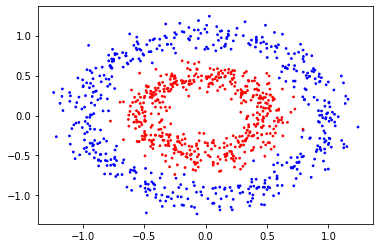

In [41]:
plt.scatter(*X_train.T, s=3, c=np.where(y_train, "red", "blue"));

- Riprendiamo la funzione che, dato un modello, visualizza come questo classifica i punti nel piano

In [42]:
def plot_class_model(X, y, model):
    plt.scatter(X[:, 0], X[:, 1])
    xlim, ylim = plt.xlim(), plt.ylim()
    mx = np.linspace(xlim[0], xlim[1], 101)
    my = np.linspace(ylim[0], ylim[1], 101)
    mx, my = np.meshgrid(mx, my)
    if hasattr(model, "predict_proba"):  # modello scikit-learn
        mz = model.predict_proba(np.c_[mx.ravel(), my.ravel()])[:, 1].reshape(mx.shape)
    else:  # modello keras
        mz = model.predict(np.c_[mx.ravel(), my.ravel()])[:, 1].reshape(mx.shape)
    plt.contourf(mx, my, mz, cmap="cool")
    plt.scatter(X[:, 0], X[:, 1], c=np.where(y, "#880000", "blue"), s=4)

- Abbiamo visto che un modello lineare non può essere addestrato efficacemente a distinguere le due classi per via della non linearità

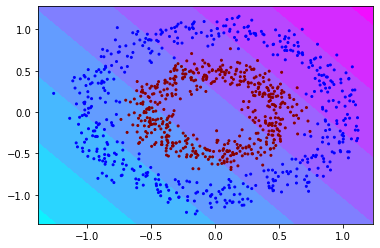

In [43]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)
model.fit(X_train, y_train)
plot_class_model(X_val, y_val, model)

- Se introduciamo manualmente i quadrati delle variabili, otteniamo un modello efficace

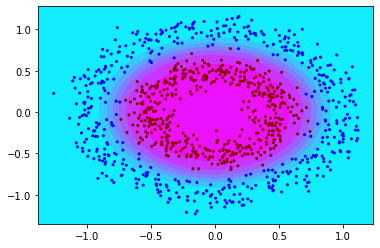

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LogisticRegression(solver="saga", random_state=42))
])
model.fit(X_train, y_train)
plot_class_model(X_val, y_val, model)

- Abbiamo però visto come con una rete neurale, senza generare manualmente delle variabili, otteniamo lo stesso risultato
- Consideriamo ad esempio una rete
  - costituita da un singolo strato nascosto di 32 nodi con attivazione ReLU
    - $\text{ReLU}(x)=\max(0,x)$
  - addestrata con discesa gradiente stocastica (SGD) per 100 epoche a minibatch di 200 istanze

In [45]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(
    hidden_layer_sizes=[32],
    activation="relu",
    solver="sgd",
    max_iter=100,
    batch_size=200,
    random_state=123
)
model.fit(X_train, y_train);

/home/rrobby/software/jupyter/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


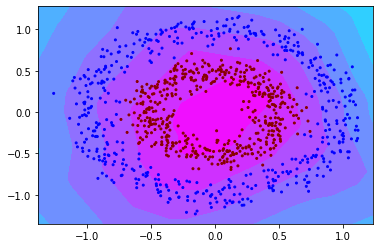

In [46]:
plot_class_model(X_val, y_val, model)

In [47]:
model.score(X_val, y_val)

0.955

- La rete ha sfruttato i nodi per approssimare quanto meglio possibile la distribuzione delle classi

## Modello di classificazione in Keras

- Vediamo ora come creare un modello di classificazione in Keras per capirne il funzionamento

- Per suddividere oggetti in N classi (quì 2), creiamo una rete neurale con **molteplici nodi di output**, uno per ciascuna classe
  - con sole due classi potremmo replicare un modello di regressione logistica con un singolo nodo di output
  - l'approccio che mostriamo è però generalizzabile ad un qualsiasi numero di classi
- Addestriamo quindi la rete in modo che il nodo di output corrispondente alla classe giusta dia un valore maggiore degli altri
- Per questo l'output atteso della rete per ciascun input, per ora rappresentato come un singolo valore 0 o 1...

In [48]:
y_train[:5]

array([1, 1, 0, 1, 1])

- ...va rappresentato come un vettore _one-hot_ di due elementi, dove
  - 0 (punti esterni) si codifica con `[1, 0]`
  - 1 (punti interni) si codifica con `[0, 1]`
- Questa rappresentazione è generalizzabile a qualsiasi numero di classi
  - ad es. la quarta di 5 classi sarebbe codificata con `[0, 0, 0, 1, 0]`

- Keras fornisce un'apposita funzione `to_categorical` per codificare l'output in questo modo

In [49]:
from tensorflow.keras.utils import to_categorical
yt_train = to_categorical(y_train)
yt_val = to_categorical(y_val)

- Otteniamo così le coppie di valori corrispondenti ai valori attesi dei due nodi di output della rete in ciascun caso

In [50]:
yt_train[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

- Addestriamo un modello con uno strato nascosto di 8 nodi con attivazione ReLU
  - specifichiamo che i valori in input sono 2, le coordinate del punto
- Nello strato di output utilizziamo due nodi, **uno per classe**
- La **funzione di attivazione `softmax`** fa in modo che l'output della rete costituisca una **distribuzione di probabilità tra le due classi**, ovvero che la somma dei due valori sia sempre 1

In [51]:
model = Sequential([
    Dense(8, activation="relu", input_dim=2),
    Dense(2, activation="softmax")
])

- Nel modello abbiamo così un totale di 42 parametri
  - 2x8 = 16 pesi e 8 bias nello strato nascosto
  - 8x2 = 16 pesi e 2 bias nello strato di output

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 24        
                                                                 
 dense_9 (Dense)             (None, 2)                 18        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


- Per la classificazione, impostiamo `categorical_crossentropy` come misura dell'errore
  - l'errore è tanto più alto quanto più la probabilità stimata per la classe corretta si allontana da 100\%
- In aggiunta alla metrica dell'errore da ottimizzare, possiamo aggiungere altre metriche di valutazione che vogliamo misurare (`metrics`)
  - calcoliamo l'`accuracy`, ovvero la percentuale di esempi classificati correttamente
- La rete sarà quindi addestrata per ridurre la `categorical_crossentropy`, ma verrà calcolata e mostrata anche la `accuracy`

In [53]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

- Addestriamo quindi la rete, passando i valori in input (le coordinate dei punti) e quelli in output (le classi nel formato one-hot encoded)

In [54]:
##outsnip:4:4
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=20)

Epoch 1/20
100/100 [==============================] - 0s 849us/step - loss: 0.7365 - accuracy: 0.4940
Epoch 2/20
100/100 [==============================] - 0s 848us/step - loss: 0.7013 - accuracy: 0.4610
Epoch 3/20
100/100 [==============================] - 0s 894us/step - loss: 0.6767 - accuracy: 0.4690
Epoch 4/20
100/100 [==============================] - 0s 870us/step - loss: 0.6554 - accuracy: 0.5140
Epoch 5/20
100/100 [==============================] - 0s 822us/step - loss: 0.6342 - accuracy: 0.5790
Epoch 6/20
100/100 [==============================] - 0s 855us/step - loss: 0.6125 - accuracy: 0.6530
Epoch 7/20
100/100 [==============================] - 0s 844us/step - loss: 0.5902 - accuracy: 0.7260
Epoch 8/20
100/100 [==============================] - 0s 871us/step - loss: 0.5680 - accuracy: 0.8300
Epoch 9/20
100/100 [==============================] - 0s 851us/step - loss: 0.5457 - accuracy: 0.8840
Epoch 10/20
100/100 [==============================] - 0s 833us/step - loss: 0.523

- In `fit_history` troviamo salvato l'andamento sia dell'errore che dell'accuratezza sul training set

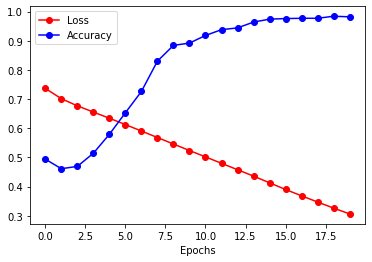

In [55]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["accuracy"], "bo-")
plt.legend(["Loss", "Accuracy"])
plt.xlabel("Epochs");

- Con `predict` otteniamo l'output "grezzo" della rete a fronte di input dati, ovvero le probabilità delle due classi

In [56]:
model.predict(X_val[:5])

1/1 [==============================] - 0s 32ms/step


array([[0.23742898, 0.76257104],
       [0.19231717, 0.8076828 ],
       [0.4410852 , 0.5589148 ],
       [0.25725883, 0.74274117],
       [0.8170395 , 0.18296057]], dtype=float32)

- Per ottenere la classe predetta per ogni istanza (quella con probabilità maggiore) possiamo applicare `argmax` riga per riga

In [57]:
np.argmax(model.predict(X_val[:5]), -1)

1/1 [==============================] - 0s 14ms/step


array([1, 1, 1, 1, 0])

- Con `evaluate` calcoliamo tutte le misure indicate in `compile`, ovvero la cross entropy e l'accuratezza

In [58]:
model.evaluate(X_val, yt_val)

32/32 [==============================] - 0s 974us/step - loss: 0.3018 - accuracy: 0.9900


[0.3017919063568115, 0.9900000095367432]

319/319 [==============================] - 0s 654us/step


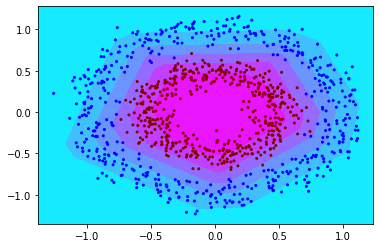

In [59]:
plot_class_model(X_val, y_val, model)

## Esercizio 2: Classificazione in Keras

- **(2a)** Definire, addestrare e calcolare l'accuratezza di un modello a rete neurale come quello sopra ma con 32 nodi nello strato nascosto invece di 8
- **(2b)** Definire, addestrare e calcolare l'accuratezza di un modello a rete neurale con due strati nascosti rispettivamente di 32 e 8 nodi, entrambi con attivazione ReLU
- Quesito: quanti parametri addestrabili ha ciascuno di questi due modelli? (rispondere prima di utilizzare `summary`)

In [60]:
##solhead:ESERCIZIO 2

In [61]:
##sol:2a (2*32 + 32 + 32*2 + 2 = 162 parametri)
model = Sequential([
    Dense(32, activation="relu", input_dim=2),
    Dense(2, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=10)
model.evaluate(X_val, yt_val)

Epoch 1/10
100/100 [==============================] - 0s 840us/step - loss: 0.7112 - accuracy: 0.4660
Epoch 2/10
100/100 [==============================] - 0s 848us/step - loss: 0.6618 - accuracy: 0.5010
Epoch 3/10
100/100 [==============================] - 0s 839us/step - loss: 0.6252 - accuracy: 0.5330
Epoch 4/10
100/100 [==============================] - 0s 851us/step - loss: 0.5887 - accuracy: 0.7340
Epoch 5/10
100/100 [==============================] - 0s 850us/step - loss: 0.5479 - accuracy: 0.8390
Epoch 6/10
100/100 [==============================] - 0s 855us/step - loss: 0.4980 - accuracy: 0.9460
Epoch 7/10
100/100 [==============================] - 0s 825us/step - loss: 0.4454 - accuracy: 0.9760
Epoch 8/10
100/100 [==============================] - 0s 863us/step - loss: 0.3965 - accuracy: 0.9780
Epoch 9/10
100/100 [==============================] - 0s 879us/step - loss: 0.3506 - accuracy: 0.9880
Epoch 10/10
32/32 [==============================] - 0s 852us/step - loss: 0.2927 

[0.29274651408195496, 0.9929999709129333]

In [62]:
##sol:2b (2*32 + 32 + 32*8 + 8 + 8*2 + 2 = 378 parametri)
model = Sequential([
    Dense(32, activation="relu", input_dim=2),
    Dense(8, activation="relu"),
    Dense(2, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=10)
model.evaluate(X_val, yt_val)

Epoch 1/10
100/100 [==============================] - 0s 857us/step - loss: 0.6542 - accuracy: 0.5460
Epoch 2/10
100/100 [==============================] - 0s 908us/step - loss: 0.5948 - accuracy: 0.7870
Epoch 3/10
100/100 [==============================] - 0s 903us/step - loss: 0.4914 - accuracy: 0.8890
Epoch 4/10
100/100 [==============================] - 0s 914us/step - loss: 0.3707 - accuracy: 0.9540
Epoch 5/10
100/100 [==============================] - 0s 903us/step - loss: 0.2561 - accuracy: 0.9800
Epoch 6/10
100/100 [==============================] - 0s 884us/step - loss: 0.1675 - accuracy: 0.9880
Epoch 7/10
100/100 [==============================] - 0s 899us/step - loss: 0.1183 - accuracy: 0.9920
Epoch 8/10
100/100 [==============================] - 0s 893us/step - loss: 0.0906 - accuracy: 0.9930
Epoch 9/10
100/100 [==============================] - 0s 895us/step - loss: 0.0708 - accuracy: 0.9920
Epoch 10/10
32/32 [==============================] - 0s 990us/step - loss: 0.0570 

[0.056979067623615265, 0.9950000047683716]

## Caso di studio: Predizione vendite

- Riprendiamo il caso di studio sui 1.000 negozi della catena europea Rossmann
- La predizione su questi dati è stata oggetto di una competizione su Kaggle: https://www.kaggle.com/c/rossmann-store-sales
  - i dati che forniamo sono versioni già parzialmente preprocessate di quelli originali su Kaggle
- Vogliamo prevedere le vendite del giorno per dimensionare adeguatamente magazzino, personale, ...

### Dataset

- I dati sono forniti divisi in due file, per addestramento e validazione

In [63]:
download("rossmann_train.csv.gz", "https://github.com/datascienceunibo/dialab2019/raw/master/Deep_Learning/rossmann_train.csv.gz")
download("rossmann_valid.csv.gz", "https://github.com/datascienceunibo/dialab2019/raw/master/Deep_Learning/rossmann_valid.csv.gz")

- Carichiamo i due file e vediamone la quantità di osservazioni

In [64]:
data_train = pd.read_csv(
    "rossmann_train.csv.gz",
    parse_dates=["Date"],
    compression="gzip",
)

In [65]:
data_val = pd.read_csv(
    "rossmann_valid.csv.gz",
    parse_dates=["Date"],
    compression="gzip",
)

In [66]:
len(data_train), len(data_val)

(804056, 40282)

- Vediamo un estratto dei due frame

In [67]:
data_train.head(4)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Customers,Sales
0,314,2015-06-19,1,0,0,1,1,3560.0,10.0,2001.0,1,31.0,2013.0,164.0,22.50,0,562,5032
1,458,2015-06-19,1,0,0,3,1,3390.0,0.0,0.0,0,0.0,0.0,24186.0,24186.25,0,688,7362
2,961,2015-06-19,1,0,0,4,3,9430.0,0.0,0.0,0,0.0,0.0,24186.0,24186.25,0,768,7764
3,132,2015-06-19,1,0,0,4,3,1040.0,0.0,0.0,1,27.0,2012.0,24186.0,35.50,0,692,7964


In [68]:
data_val.head(4)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Customers,Sales
0,1,2015-07-31,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75,0,555,5263
1,747,2015-07-31,1,0,1,3,3,45740.0,8.0,2008.0,0,0.0,0.0,83.0,24187.75,0,826,10708
2,772,2015-07-31,1,0,1,4,3,1850.0,0.0,0.0,0,0.0,0.0,24187.0,24187.75,0,635,5224
3,752,2015-07-31,1,0,1,1,1,970.0,3.0,2013.0,1,31.0,2013.0,28.0,24.00,0,565,7763


### Descrizione variabili

- Ogni riga è un'osservazione relativa ad un singolo negozio in una certa data, indicati dalle colonne `Store` e `Date`
- Le ultime due colonne `Customers` and `Sales` indicano rispettivamente il numero di clienti e il ricavo totale delle vendite per quel giorno in quel negozio
- Le altre colonne riportano informazioni note a priori relative a negozio e giorno
  - applicazione di promozioni (`Promo*`, `IsPromoMonth`)
  - festività (`StateHoliday`, `SchoolHoliday`)
  - tipologia di negozio (`StoreType`, `Assortment`)
  - distanza da negozi concorrenti e loro data di apertura (`Competition*`)
- L'obiettivo è prevedere da queste informazioni il ricavo totale (`Sales`)
- Definiamo le serie `y_*` con i valori di `Sales` per training e validation set

In [69]:
y_train = data_train["Sales"]
y_val = data_val["Sales"]

- Il ricavo totale `Sales` è ovviamente strettamente proporzionale al numero di clienti `Customers`
  - selezioniamo con `sample(N)` un numero limitato di campioni casuali per creare il grafico con più efficienza
- Non possiamo però usare la variabile `Customers` nella predizione, in quanto proprio come `Sales` non è un'informazione nota a priori

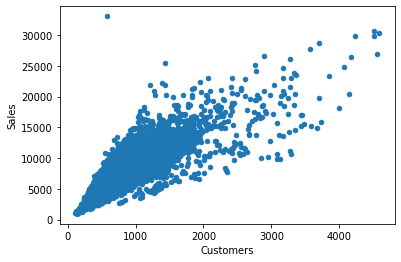

In [70]:
data_train.sample(10000).plot.scatter("Customers", "Sales");

### Selezione e preprocessamento delle variabili

Consideriamo tre gruppi di variabili da utilizzare per la predizione

- quelle con un valore propriamente numerico oppure binarie (0/1), che non richiedono preprocessing
  - distanza dalla concorrenza, da quanto tempo è in corso una promozione, ...
  - se sono in corso delle promozioni, se è giorno di chiusura delle scuole, ...
- quelle categoriche con più di 2 valori, a cui applichiamo il one-hot encoding
- la colonna della data `Date`, da cui vogliamo estrarre singoli campi (es. giorno della settimana)

In [71]:
numeric_cols = [
    "Promo", "SchoolHoliday", "CompetitionDistance",
    "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear",
    "Promo2", "Promo2SinceWeek", "Promo2SinceYear",
    "CompetitionOpen", "PromoOpen", "IsPromoMonth"
]

In [72]:
categorical_cols = ["StateHoliday", "StoreType", "Assortment"]

In [73]:
# funzione per l'estrazione dei campi data
def extract_date_fields(X):
    result = {}
    for col in X.columns:
        result[f"{col}_day"] = X[col].dt.day
        result[f"{col}_month"] = X[col].dt.month
        result[f"{col}_dayofweek"] = X[col].dt.dayofweek
    return pd.DataFrame(result)

- Utilizziamo quindi un `ColumnTransformer` per combinare insieme tutte le colonne preprocessate opportunamente
  - le colonne numeriche sono prese così come sono (_passthrough_)
  - alle colonne categoriche è applicato il one-hot encoding
  - dalla colonna `Date` sono estratti i componenti della data
- Mettiamo questo filtro in pipeline con uno `StandardScaler` per standardizzare tutte le variabili

In [74]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
date_transformer = FunctionTransformer(extract_date_fields)
transformer = Pipeline([
    ("cols", ColumnTransformer([
        ("num" , "passthrough",    numeric_cols),
        ("cat" , OneHotEncoder(),  categorical_cols),
        ("date", date_transformer, ["Date"]),
    ])),
    ("scaler", StandardScaler()),
])

- Applichiamo il filtro composito al training e al validation set
  - le colonne non specificate (`Sales` e `Customers`) sono scartate (_drop_) di default dal `ColumnTransformer`

In [75]:
X_train = transformer.fit_transform(data_train)
X_val = transformer.transform(data_val)

- Eseguiamo infine la standardizzazione della variabile da predire (`Sales`) con un altro `StandardScaler`

In [76]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(data_train["Sales"].values[:, None]).ravel()
y_val = scaler_y.transform(data_val["Sales"].values[:, None]).ravel()

## Modelli di regressione sui dati Rossmann

- Testiamo come baseline un modello di regressione lineare

In [77]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train);

- Con `score` calcoliamo l'accuratezza calcolata col coefficiente R²

In [78]:
model.score(X_val, y_val)

0.24711019131678047

- Nella competizione Kaggle viene usata come misura di riferimento il _Root Mean Squared Percentage Error_ (RMSPE)
$$ \textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2} $$
- Definiamo una funzione `rmspe` per calcolare tale metrica dati i valori attesi e le predizioni, avendo cura di riportare i valori standardizzati nella scala originale

In [79]:
def rmspe(y_real, y_pred):
    y_real = scaler_y.inverse_transform(y_real[:, None])
    y_pred = scaler_y.inverse_transform(y_pred[:, None])
    return np.sqrt(np.mean((y_pred/y_real-1) ** 2))

- Il modello di regressione lineare ottiene un RMSPE pari a...

In [80]:
rmspe(y_val, model.predict(X_val))

0.4985096780147238

- Vediamo i risultati ottenibili con reti neurali
- Iniziamo da una rete con un singolo strato nascosto con attivazione ReLU
- Per la dimensione dell'input leggiamo direttamente il numero di colonne di X

In [81]:
model = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

- Vediamo come in un problema reale come questo il numero di parametri da addestrare sia sull'ordine delle migliaia

In [82]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               3328      
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
8041/8041 [==============================] - 8s 944us/step - loss: 0.6993
Epoch 2/5
8041/8041 [==============================] - 8s 948us/step - loss: 0.6367
Epoch 3/5
8041/8041 [==============================] - 7s 908us/step - loss: 0.6063
Epoch 4/5
8041/8041 [==============================] - 7s 906us/step - loss: 0.5852
Epoch 5/5
8041/8041 [==============================] - 7s 904us/step - loss: 0.5701


- Dati dei valori in input, con `predict` otteniamo i valori predetti (normalizzati)

In [84]:
model.predict(X_val[:5])

1/1 [==============================] - 0s 32ms/step


array([[0.6864053 ],
       [1.1333137 ],
       [0.33067322],
       [0.5371418 ],
       [0.87771475]], dtype=float32)

- Calcoliamo l'RMSPE dalle predizioni come visto sopra

In [85]:
rmspe(y_val, model.predict(X_val).ravel())

1259/1259 [==============================] - 1s 648us/step


0.38612357869338565

- Testiamo ora una rete con 3 strati nascosti con diversi numeri di nodi
  - ogni strato idealmente corrisponde ad una rappresentazione diversa dell'input

In [86]:
model = Sequential([
    Dense(512, activation="relu", input_dim=X_train.shape[1]),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

- Per via dei molteplici strati, il numero di parametri da addestrare aumenta sensibilmente

In [87]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 512)               13312     
                                                                 
 dense_18 (Dense)            (None, 128)               65664     
                                                                 
 dense_19 (Dense)            (None, 32)                4128      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 83,137
Trainable params: 83,137
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
8041/8041 [==============================] - 14s 2ms/step - loss: 0.6071
Epoch 2/5
8041/8041 [==============================] - 14s 2ms/step - loss: 0.4225
Epoch 3/5
8041/8041 [==============================] - 14s 2ms/step - loss: 0.3533
Epoch 4/5
8041/8041 [==============================] - 14s 2ms/step - loss: 0.3217
Epoch 5/5
8041/8041 [==============================] - 14s 2ms/step - loss: 0.3003


In [89]:
rmspe(y_val, model.predict(X_val).ravel())

1259/1259 [==============================] - 1s 761us/step


0.24730296826621215

- Siamo così riusciti a migliorare il RMSPE rispetto ai modelli di regressione semplici
  - I risultati sono ulteriormente migliorabili aumentando le epoche di addestramento

## Regolarizzazione

- Nelle reti neurali si possono introdurre diversi accorgimenti per evitare l'overfitting
- Come in altri modelli, possiamo utilizzare la regolarizzazione per evitare che i parametri del modello assumano valori elevati
- I tipi di regolarizzazione applicabili sono `l2` (ridge), `l1` (lasso) o entrambe (elastic net)
- La regolarizzazione può essere applicata sui pesi (_kernel_), sui bias e/o sull'output della funzione di attivazione (_activity_)
- Nell'esempio seguente riprendiamo la rete con un singolo strato nascosto applicando la regolarizzazione L2 ai pesi

In [90]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    Dense(128, activation="relu", kernel_regularizer=l2(0.001), input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [91]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
8041/8041 [==============================] - 7s 893us/step - loss: 0.7280
Epoch 2/5
8041/8041 [==============================] - 7s 890us/step - loss: 0.6688
Epoch 3/5
8041/8041 [==============================] - 7s 888us/step - loss: 0.6466
Epoch 4/5
8041/8041 [==============================] - 7s 884us/step - loss: 0.6367
Epoch 5/5
8041/8041 [==============================] - 7s 883us/step - loss: 0.6292


In [92]:
rmspe(y_val, model.predict(X_val).ravel())

1259/1259 [==============================] - 1s 623us/step


0.37207005661217785

## Dropout

- Il _dropout_, applicato nell'addestramento della rete, azzera ad ogni batch alcuni input casuali in uno strato
  - in fase di predizione (inferenza) non cambia nulla
- In questo modo la rete si addestra su informazioni incomplete, con possibile riduzione dell'overfitting
- Riprendiamo come esempio la rete con tre strati nascosti usata sopra
- Introduciamo dopo il primo strato nascosto uno strato `Dropout`, in cui specifichiamo la frazione di input da azzerare (ad es 10\%)
  - lo strato dropout è "astratto", non introduce nuovi nodi o nuovi parametri da addestrare

In [93]:
from tensorflow.keras.layers import Dropout
model = Sequential([
    Dense(512, activation="relu", input_dim=X_train.shape[1]),
    Dropout(0.1),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [94]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 512)               13312     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               65664     
                                                                 
 dense_25 (Dense)            (None, 32)                4128      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 83,137
Trainable params: 83,137
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
8041/8041 [==============================] - 16s 2ms/step - loss: 0.6317
Epoch 2/5
8041/8041 [==============================] - 16s 2ms/step - loss: 0.4844
Epoch 3/5
8041/8041 [==============================] - 16s 2ms/step - loss: 0.4069
Epoch 4/5
8041/8041 [==============================] - 16s 2ms/step - loss: 0.3691
Epoch 5/5
8041/8041 [==============================] - 16s 2ms/step - loss: 0.3426


In [96]:
rmspe(y_val, model.predict(X_val).ravel())

1259/1259 [==============================] - 1s 774us/step


0.254112306615975

- Si noti come l'errore sul training set rimanga leggermente più alto rispetto al modello senza dropout, ma il RMSPE sul validation set è simile

## Integrazione tra scikit-learn e Keras

- Lavorando in scikit-learn abbiamo visto diversi strumenti utili per testare e ottimizzare i modelli di predizione (cross validation, grid search, ...)
- È possibile riutilizzare gli stessi struenti su modelli Keras?
- Keras fornisce le classi `KerasClassifier` e `KerasRegressor` che **incapsulano dei modelli Keras nell'API di scikit-learn**, permettendo così il loro uso all'interno ad es. di una grid search
  - _queste classi non saranno più mantenute in futuro da Keras, si veda come alternativa la libreria [SciKeras](https://github.com/adriangb/scikeras)_

- Iniziamo definendo una funzione che restituisce un semplice modello Keras compilato (ma non addestrato)

In [97]:
def sample_net():
    model = Sequential([
        Dense(16, activation="relu", input_dim=X_train.shape[1]),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

- Creiamo quindi un oggetto `KerasRegressor`, a cui vanno passati come iperparametri
  - una funzione come quella sopra che definisce la struttura della rete
  - i parametri per l'addestramento, quali numero di epoche e batch size (usiamo quì parametri "scarsi" per ridurre i tempi)

In [98]:
##noerr
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn=sample_net, epochs=3, batch_size=1000)

/tmp/ipykernel_30594/1715313649.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=sample_net, epochs=3, batch_size=1000)


- L'oggetto `KerasRegressor` fornisce l'API standard di scikit-learn, per cui possiamo addestrarlo con `fit`...
  - passiamo solamente il training set, gli altri parametri sono già passati al costruttore

In [99]:
model.fit(X_train, y_train);

Epoch 1/3
805/805 [==============================] - 1s 921us/step - loss: 0.8538
Epoch 2/3
805/805 [==============================] - 1s 937us/step - loss: 0.7369
Epoch 3/3
805/805 [==============================] - 1s 935us/step - loss: 0.7214


- ...e ottenere le predizioni con `predict`

In [100]:
y_pred = model.predict(X_val)
r2_score(y_val, y_pred)

41/41 [==============================] - 0s 722us/step


0.32072300749971394

- La funzione che costruisce la rete può contenere dei parametri...
  - quì ad esempio rendiamo il numero di nodi nello strato nascosto un parametro `nodes`

In [101]:
def sample_net(nodes):
    model = Sequential([
        Dense(nodes, activation="relu", input_dim=X_train.shape[1]),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

- ...il cui valore può essere impostato come iperparametro nel costruttore di `KerasRegressor`

In [102]:
##noerr
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn=sample_net, nodes=32, epochs=3, batch_size=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
r2_score(y_val, y_pred)

Epoch 1/3


/tmp/ipykernel_30594/4131286876.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=sample_net, nodes=32, epochs=3, batch_size=1000)


805/805 [==============================] - 1s 1ms/step - loss: 0.8099
Epoch 2/3
805/805 [==============================] - 1s 1ms/step - loss: 0.7213
Epoch 3/3
41/41 [==============================] - 0s 790us/step


0.33514103646672844

- Questo permette una migliore integrazione con scikit-learn: in particolare possiamo effettuare una grid search sui parametri che influenzano la struttura della rete

In [103]:
from sklearn.model_selection import GridSearchCV, KFold

model = KerasRegressor(build_fn=sample_net, epochs=3)
grid = {
    "nodes": [16, 32],
    "batch_size": [500, 1000]
}
gs = GridSearchCV(model, grid, cv=KFold(3, shuffle=True))
gs.fit(X_train, y_train)
gs.best_params_

Epoch 1/3


/tmp/ipykernel_30594/435823841.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=sample_net, epochs=3)


1073/1073 [==============================] - 1s 846us/step - loss: 0.8667
Epoch 2/3
1073/1073 [==============================] - 1s 859us/step - loss: 0.7405
Epoch 3/3
537/537 [==============================] - 0s 707us/step - loss: 0.7156
Epoch 1/3
1073/1073 [==============================] - 1s 858us/step - loss: 0.8858
Epoch 2/3
1073/1073 [==============================] - 1s 868us/step - loss: 0.7334
Epoch 3/3
537/537 [==============================] - 0s 705us/step - loss: 0.7251
Epoch 1/3
1073/1073 [==============================] - 1s 856us/step - loss: 0.8454
Epoch 2/3
1073/1073 [==============================] - 1s 875us/step - loss: 0.7361
Epoch 3/3
537/537 [==============================] - 0s 704us/step - loss: 0.7221
Epoch 1/3
1073/1073 [==============================] - 1s 948us/step - loss: 0.8534
Epoch 2/3
1073/1073 [==============================] - 1s 936us/step - loss: 0.7276
Epoch 3/3
537/537 [==============================] - 0s 727us/step - loss: 0.6974
Epoch 1/3


{'batch_size': 500, 'nodes': 32}

## Proposte di esercizio

Testare sullo stesso problema altre configurazioni di reti neurali
- modificando il numero di strati e di nodi in essi
- introducendo diversi tipi di regolarizzazione con diversa intensità in diversi strati
- introducendo il dropout con diversa intensità in diversi strati
- cambiando il numero di epoche o la batch size

Consultare la [guida di Keras](https://keras.io/api/) per dettagli su queste e altre opzioni (altre funzioni di attivazione, inizializzazione dei pesi, algoritmi di ottimizzazione e relative opzioni, ...)

## Caso di studio: Riconoscimento attività umane

- Gli smartphone moderni contengono diversi **sensori di movimento**, quali accelerometro e oscilloscopio
- È possibile, raccogliendo dati da questi sensori, risconoscere **quale attività sta svolgendo una persona**?
  - È in piedi fermo? Sta camminando? È seduto? ...
- Vediamo come addestrare una rete neurale a riconoscere l'attività svolta da una sequenza di letture dei sensori
- Tale rete può essere in seguito integrata in un'app per smartphone, ad es. per il tracking dell'attività fisica

### Dataset

- Utilizziamo un set di dati di letture da sensori diponibile online su https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones
- Sono distinte **6 classi relative a diverse attività** o posizioni...
  - camminare, salire scale, scendere scale, seduti, in piedi, sdraiati
- ...svolte da 30 persone mentre indossavano uno smartphone
- 50 volte al secondo sono stati campionati **9 valori**
  - 3 sensori (accelerazione con e senza gravità, rotazione) per 3 assi (XYZ)
- Il dataset finale ha **10.299 sequenze** (tra training e test), ciascuna contenente **128 campioni** di ciascuna delle 9 variabili
  - a ciascuna sequenza è associata una delle 6 classi

- Scarichiamo il dataset in formato ZIP dal Web...

In [104]:
download("HARDataset.zip", "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip")

- ...ed estraiamo i file

In [105]:
from zipfile import ZipFile
if not os.path.isdir("UCI HAR Dataset"):
    with ZipFile("HARDataset.zip") as zipf:
        zipf.extractall()

- I dati sono già divisi in due set `train` e `test`
- Nella directory `Inertial Signals` di ciascuno si trovano i file con i dati grezzi ottenuti dai sensori
- Sono considerati 3 diversi sensori:
  - `total_acc`: accelerazione (accelerometro)
  - `body_acc`: accelerazione senza la forza di gravità
  - `body_gyro`: rotazione (giroscopio)
- Per ogni sensore si considerano tre assi x, y, z come da figura:

![x da sinistra verso destra, y dal basso verso l'alto, z da dietro verso davanti](https://developer.android.com/images/axis_device.png)

- La seguente funzione carica tutti i dati descritti sopra dai file estratti

In [106]:
def load_dataset(prefix, sensors):
    def load_file(filepath):
        dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
        return dataframe.values
    def load_dataset_group(group, prefix, sensors):
        filepath = prefix + group + "/Inertial Signals/"
        filenames = ["{}_{}_{}.txt".format(sensor, axis, group)
                     for sensor in sensors for axis in "xyz"]
        X_data = [load_file(filepath + name) for name in filenames]
        X = np.dstack(X_data)
        y = load_file(prefix + group + '/y_'+group+'.txt').ravel() - 1
        return X, y
    trainX, trainy = load_dataset_group('train', prefix, sensors)
    testX, testy = load_dataset_group('test', prefix, sensors)
    return trainX, trainy, testX, testy

- Invochiamo la funzione, specificando i sensori per cui vogliamo caricare i dati
  - si può eventualmente usare solo una parte dei sensori, ad es. per smartphone dotati solo di alcuni di essi

In [107]:
X_train, y_train, X_test, y_test = load_dataset(
    "UCI HAR Dataset/",
    ["total_acc", "body_acc", "body_gyro"]
)

- Otteniamo due dataset "train" e "test", costituiti rispettivamente da 7.352 e da 2.947 osservazioni, ovvero sequenze raccolte in diversi momenti o da diverse persone
- Gli array `X_*` a **3 dimensioni** (assi) contengono i valori campionati dai sensori
  - lungo l'asse 0 abbiamo le **N sequenze**
  - lungo l'asse 1 abbiamo i **128 istanti**
  - lungo l'asse 2 abbiamo i **9 valori campionati** per ogni istante (3 sensori per 3 assi)
- In pratica, il valore `X_train[i,j,k]` è il valore di indice k campionato all'istante j nella i-esima sequenza del training set
- **Ciascuna istanza** di training e di test set è quindi **rappresentata con una matrice a 2 dimensioni** piuttosto che con un vettore come visto finora

In [108]:
X_train.shape

(7352, 128, 9)

In [109]:
X_test.shape

(2947, 128, 9)

- Gli array `y_*` a 1 dimensione contiene le etichette delle finestre temporali
  - le etichette sono comprese tra 0 e 5

In [110]:
y_train.shape

(7352,)

In [111]:
y_test.shape

(2947,)

- Carichiamo dal file `activity_labels.txt` i nomi delle attività riconosciute

In [112]:
with open("UCI HAR Dataset/activity_labels.txt", "rt") as f:
    labels = [line.split(" ")[1].strip() for line in f]

In [113]:
labels

['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING']

- Possiamo usarle per vedere la distribuzione di osservazioni delle diverse attività in training e test set

In [114]:
pd.Series(labels)[y_train].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
dtype: int64

In [115]:
pd.Series(labels)[y_test].value_counts()

LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
dtype: int64

- Codifichiamo le etichette (y) in vettori one-hot da usare come output atteso della rete

In [116]:
from tensorflow.keras.utils import to_categorical
yt_train = to_categorical(y_train)
yt_test = to_categorical(y_test)

- I valori in ingresso hanno già media vicina a 0 e dev. standard contenuta, non è necessario standardizzarli

In [117]:
X_train.mean((0, 1))

array([ 8.04749279e-01,  2.87554865e-02,  8.64980163e-02, -6.36303058e-04,
       -2.92296856e-04, -2.75299412e-04,  5.06464674e-04, -8.23780831e-04,
        1.12948439e-04])

In [118]:
X_train.std((0, 1))

array([0.41411195, 0.39099543, 0.35776881, 0.19484634, 0.12242748,
       0.10687881, 0.40681506, 0.38185432, 0.25574314])

- Dalle dimensioni degli array ricaviamo
  - il numero di campioni per ogni sequenza (128)
  - il numero di valori per ogni campione (9)
  - il numero di possibili classi (6)

In [119]:
n_timesteps = X_train.shape[1]  # = 128
n_features = X_train.shape[2]   # = 9
n_outputs = yt_train.shape[1]   # = 6

- Costruiamo una prima rete per la classificazione con un singolo strato nascosto
- In input usiamo uno strato `Flatten` per convertire ciascuna **matrice 128x9** con cui è rappresentata una sequenza di campioni in un **vettore di 128*9 = 1.152 elementi**
  - questo strato **cambia la rappresentazione dei dati** per renderla compatibile con gli strati `Dense`, che si aspettano un vettore per ogni istanza
  - **non** vengono aggiunti nodi o parametri da addestrare
  - con `input_shape` indichiamo la dimensione attesa della matrice
- Essendo un problema di classificazione, in output usiamo uno strato con **attivazione softmax con 6 nodi, uno per classe**

In [120]:
from tensorflow.keras.layers import Flatten
model = Sequential([
    Flatten(input_shape=(n_timesteps, n_features)),
    Dense(32, activation="relu"),
    Dense(n_outputs, activation="softmax")
])

- Vediamo la struttura della rete con la forma dell'output e il numero di parametri per ogni strato

In [121]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense_57 (Dense)            (None, 32)                36896     
                                                                 
 dense_58 (Dense)            (None, 6)                 198       
                                                                 
Total params: 37,094
Trainable params: 37,094
Non-trainable params: 0
_________________________________________________________________


- Come visto le altre volte, compiliamo il modello specificando
  - di utilizzare l'algoritmo di ottimizzazione _Adam_ (variante della discesa gradiente stocastica)
  - di ottimizzare (minimizzandola) la _categorical cross entropy_, tanto più alta quanto più le probabilità date alle classi corrette si allontanano dal 100\%
  - di calcolare in parallelo anche l'accuratezza (percentuale di classificazioni corrrette)

In [122]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

- Addestriamo quindi il modello con `fit`, specificando
  - il training set (input e relativi output attesi)
  - il numero di epoche di addestramento
  - la _batch size_, il numero di osservazioni (finestre temporali) in ciascun minibatch di addestramento

In [123]:
%time model.fit(X_train, yt_train, epochs=10, batch_size=20)

Epoch 1/10
368/368 [==============================] - 1s 987us/step - loss: 0.7879 - accuracy: 0.7289
Epoch 2/10
368/368 [==============================] - 0s 1ms/step - loss: 0.3608 - accuracy: 0.8811
Epoch 3/10
368/368 [==============================] - 0s 1ms/step - loss: 0.2343 - accuracy: 0.9197
Epoch 4/10
368/368 [==============================] - 0s 1ms/step - loss: 0.1776 - accuracy: 0.9373
Epoch 5/10
368/368 [==============================] - 0s 1ms/step - loss: 0.1486 - accuracy: 0.9464
Epoch 6/10
368/368 [==============================] - 0s 1ms/step - loss: 0.1348 - accuracy: 0.9499
Epoch 7/10
368/368 [==============================] - 0s 1ms/step - loss: 0.1198 - accuracy: 0.9547
Epoch 8/10
368/368 [==============================] - 0s 1ms/step - loss: 0.1125 - accuracy: 0.9557
Epoch 9/10
368/368 [==============================] - 0s 1ms/step - loss: 0.1103 - accuracy: 0.9551
Epoch 10/10
368/368 [==============================] - 0s 1ms/step - loss: 0.1079 - accuracy: 0.95

- Usiamo _evaluate_ per calcolare sul validation set le stesse metriche di valutazione mostrate sul training set durante l'addestramento

In [124]:
model.evaluate(X_test, yt_test)

93/93 [==============================] - 0s 855us/step - loss: 0.7216 - accuracy: 0.8541


[0.7215678691864014, 0.8540889024734497]

- L'accuratezza (il secondo numero) assume valori indicativamente tra 85\% e 90\% (suscettibili di casualità)
- Salviamo questo modello in una variabile a parte per vedere successivamente come esportarlo...

In [125]:
model_to_export = model

- Possiamo aggiungere uno strato nascosto per rendere più accurata la rete

In [126]:
model = Sequential([
    Flatten(input_shape=(n_timesteps, n_features)),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(n_outputs, activation="softmax")
])

- Si noti che il numero di parametri da addestrare si alza sensibilmente...

In [127]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_59 (Dense)            (None, 128)               147584    
                                                                 
 dense_60 (Dense)            (None, 64)                8256      
                                                                 
 dense_61 (Dense)            (None, 6)                 390       
                                                                 
Total params: 156,230
Trainable params: 156,230
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [129]:
%time model.fit(X_train, yt_train, epochs=10, batch_size=20)

Epoch 1/10
368/368 [==============================] - 1s 1ms/step - loss: 0.4486 - accuracy: 0.8373
Epoch 2/10
368/368 [==============================] - 1s 1ms/step - loss: 0.1693 - accuracy: 0.9336
Epoch 3/10
368/368 [==============================] - 1s 1ms/step - loss: 0.1274 - accuracy: 0.9482
Epoch 4/10
368/368 [==============================] - 1s 1ms/step - loss: 0.1092 - accuracy: 0.9540
Epoch 5/10
368/368 [==============================] - 1s 1ms/step - loss: 0.1011 - accuracy: 0.9557
Epoch 6/10
368/368 [==============================] - 1s 1ms/step - loss: 0.0950 - accuracy: 0.9572
Epoch 7/10
368/368 [==============================] - 1s 1ms/step - loss: 0.0891 - accuracy: 0.9591
Epoch 8/10
368/368 [==============================] - 1s 1ms/step - loss: 0.1623 - accuracy: 0.9421
Epoch 9/10
368/368 [==============================] - 1s 1ms/step - loss: 0.0993 - accuracy: 0.9561
Epoch 10/10
368/368 [==============================] - 1s 1ms/step - loss: 0.0821 - accuracy: 0.9622

In [130]:
model.evaluate(X_test, yt_test)

93/93 [==============================] - 0s 964us/step - loss: 0.4085 - accuracy: 0.9006


[0.4084576666355133, 0.9005768299102783]

## Reti convoluzionali

- Negli input delle reti neurali è spesso necessario **riconoscere dei pattern** che possono essere presenti **in diverse porzioni** dell'input
  - nel caso comune delle immagini, si vogliono riconoscere dei particolari **indipendentemente dal punto in cui si trovano**
  - nel caso di studio corrente, potremmo riconoscere delle brevi sequenze temporali di valori che sono peculiari di attività specifiche
- Le reti _convoluzionali_ utilizzano strati con connessioni "locali" e pesi condivisi
  - ogni nodo riceve input solamente **da nodi vicini tra loro** nello strato inferiore, assumendo che corrispondano a **porzioni di spazio o di tempo**
  - **gli stessi pesi sono applicati a tutti i nodi**, in modo lo stesso pattern sia cercato sull'intero intervallo di spazio o di tempo analizzato

- Inseriamo all'inizio della rete uno strato `Conv1D` impostando il numero e la lunghezza dei pattern da cercare
  - ad esempio poniamo di cercare parallelamente **16 pattern** con lunghezza di **15 passi temporali** ciascuno
- L'input atteso dallo strato `Conv1D` per ogni osservazione è una matrice MxN con una sequenza di M campioni di N valori indipendenti ("canali")
  - i set di dati che utilizziamo hanno già questo formato, possono essere dati in input direttamente
- L'output per ogni osservazione sarà una matrice MxN che indica in che misura ciascuno degli N pattern è stato individuato in ciascuno degli M punti dell'input
  - come sopra, applichiamo `Flatten` ad esso per convertire ciascuna matrice in un vettore lineare di nodi

In [131]:
from tensorflow.keras.layers import Conv1D
model = Sequential([
    Conv1D(16, 15, input_shape=(n_timesteps, n_features)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(n_outputs, activation="softmax")
])

- Dal sommario, vediamo che lo strato convoluzionale ha un numero di parametri nettamente inferiore rispetto ad un tipico strato denso
  - per ognuno dei 16 pattern abbiamo 15x9 pesi e un bias condivisi su 114 nodi, per un totale di 2.176 parametri
- Lo strato restituisce 114x16 valori, ovvero 16 pattern cercati nelle 114 (128-15+1) sequenze possibili di 15 valori su 128

In [132]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 114, 16)           2176      
                                                                 
 flatten_2 (Flatten)         (None, 1824)              0         
                                                                 
 dense_62 (Dense)            (None, 64)                116800    
                                                                 
 dense_63 (Dense)            (None, 6)                 390       
                                                                 
Total params: 119,366
Trainable params: 119,366
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [134]:
%time model.fit(X_train, yt_train, epochs=10, batch_size=20)

Epoch 1/10
368/368 [==============================] - 1s 2ms/step - loss: 0.5052 - accuracy: 0.8137
Epoch 2/10
368/368 [==============================] - 1s 2ms/step - loss: 0.2254 - accuracy: 0.9166
Epoch 3/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1453 - accuracy: 0.9427
Epoch 4/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1370 - accuracy: 0.9444
Epoch 5/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1250 - accuracy: 0.9475
Epoch 6/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1246 - accuracy: 0.9510
Epoch 7/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1226 - accuracy: 0.9476
Epoch 8/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1145 - accuracy: 0.9510
Epoch 9/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1213 - accuracy: 0.9493
Epoch 10/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1393 - accuracy: 0.9475

In [135]:
model.evaluate(X_test, yt_test)

93/93 [==============================] - 0s 1ms/step - loss: 0.6270 - accuracy: 0.8941


[0.626990556716919, 0.8941296339035034]

## Reti ricorrenti

- Al contrario delle reti viste finora, una rete _ricorrente_ contiene connessioni cicliche tra nodi
- A queste reti ciascun input è una sequenza fornita **in più passi temporali**
  - nel nostro caso, si immagini di fornire le 128 letture dei sensori **una dopo l'altra** invece che in blocco
- Tramite le connessioni cicliche, **la rete mantiene uno stato** da un passo all'altro
- L'output della rete ad un passo $t$ dipende sia dall'input allo stesso passo $t$ che dallo stato che si è creato in seguito agli input precedenti
- Per usare una rete ricorrente, nei dati di addestramento e test deve essere presente **una dimensione temporale**
  - come nel caso di studio corrente, dove ogni osservazione è una sequenza di 128 campioni
- Le reti ricorrenti possono potenzialmente riconoscere correlazioni tra dati forniti in passi temporali diversi, anche distanti

- Keras fornisce diversi tipi di strati ricorrenti, tra cui le _Gated Recurrent Unit_ (GRU)
  - ad ogni passo temporale $t$ lo strato GRU calcola un output di N valori $h(t)$ in funzione sia dell'input attuale $x(t)$ che dell'output precedente $h(t-1)$
- In addestramento e test, dobbiamo fornire le osservazioni complete di tutti gli istanti temporali
  - ciascuna osservazione è una matrice MxN, rappresentante una sequenza di durata M di vettori di misura N
  - nel nostro caso, sequenze di 128 campioni di 9 valori
- Di default, solo l'output di GRU all'ultimo passo temporale è considerato per determinare l'output dato dalla rete ad ogni osservazione
  - questo output è un vettore, può essere passato direttamente ad uno strato `Dense`

In [136]:
from tensorflow.keras.layers import GRU
model = Sequential([
    GRU(64, activation="relu", input_shape=(n_timesteps, n_features)),
    Dense(n_outputs, activation="softmax")
])

- Anche in questo caso il numero di parametri è molto inferiore rispetto ad un MLP ordinario, in quanto gli stessi pesi vengono riutilizzati attraverso i 128 passaggi temporali

In [137]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                14400     
                                                                 
 dense_64 (Dense)            (None, 6)                 390       
                                                                 
Total params: 14,790
Trainable params: 14,790
Non-trainable params: 0
_________________________________________________________________


In [138]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

- Il tempo per l'addestramento aumenta, in quanto l'errore su ciascuna osservazione va derivato attraverso i 128 passi temporali (_backpropagation through time_)

In [139]:
%time model.fit(X_train, yt_train, epochs=5, batch_size=100)

Epoch 1/5
74/74 [==============================] - 3s 34ms/step - loss: 1.4933 - accuracy: 0.4638
Epoch 2/5
74/74 [==============================] - 2s 34ms/step - loss: 0.9500 - accuracy: 0.6370
Epoch 3/5
74/74 [==============================] - 2s 34ms/step - loss: 0.6239 - accuracy: 0.7391
Epoch 4/5
74/74 [==============================] - 3s 34ms/step - loss: 0.4767 - accuracy: 0.8037
Epoch 5/5
74/74 [==============================] - 3s 34ms/step - loss: 0.3676 - accuracy: 0.8598
CPU times: user 31.6 s, sys: 2.25 s, total: 33.8 s
Wall time: 13.5 s


In [140]:
model.evaluate(X_test, yt_test)

93/93 [==============================] - 1s 6ms/step - loss: 0.6319 - accuracy: 0.8073


[0.6318542957305908, 0.8072616457939148]

## Deployment del modello con TensorFlow Lite

- TensorFlow Lite è un framework per il deep learning destinato a dispositivi mobili ed embedded
- Si usa per eseguire inferenze (stime e predizioni) su modelli che vengono caricati già addestrati sul dispositivo
  - l'inferenza richiede generalmente molte meno risorse rispetto all'addestramento
- Sul Web esistono diversi modelli preaddestrati per diversi task
  - riconoscimento immagini, natural language processing, ...
- Possiamo in aggiunta esportare i modelli addestrati con TensorFlow (anche tramite Keras)
- Nel nostro caso di studio, possiamo esportare il modello che riconosce le attività, per poi utilizzarlo ad es. all'interno di un'app mobile

## Esportazione del modello

- Creiamo un oggetto `TFLiteConverter` passando il modello Keras addestrato
  - NB: funziona solo su modelli che usano il package `tensorflow.keras`

In [141]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_export)

- Utilizziamone il metodo `convert` per ottenere la rappresentazione binaria
  - NB: eseguendo da Jupyter, si ha errore se TensorFlow è installato in un ambiente virtuale diverso da quello di Jupyter

In [142]:
##noerr
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpo3pzqnnv/assets


2022-06-01 12:07:44.270772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-06-01 12:07:44.270798: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-06-01 12:07:44.271347: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpo3pzqnnv
2022-06-01 12:07:44.272161: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-06-01 12:07:44.272176: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpo3pzqnnv
2022-06-01 12:07:44.274322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-06-01 12:07:44.274966: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-01 12:07:44.303872: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpo3pzqnnv
2022-06

- Esportiamo quindi tale rappresentazione in un file

In [143]:
with tf.io.gfile.GFile("model.tflite", "wb") as f:
    f.write(tflite_model)

## Uso all'interno di un'app Android

- Vediamo in breve come si integra il modello esportato in un'app Android
- Per iniziare, dichiariamo TensorFlow Lite come dipendenza nel file `build.gradle` del progetto

```groovy
repositories {
  // ... altre repository ...
  maven {
    url 'https://google.bintray.com/tensorflow'
  }
}
dependencies {
  // ... altre dipendenze ...
  implementation 'org.tensorflow:tensorflow-lite:+'
}
```

- Un modello TF Lite è rappresentato a run-time da un oggetto `Interpreter`
- Creiamo tale oggetto passando un riferimento al file o direttamente un buffer con i dati
  - si può trattare di un file salvato nel file system, es. scaricato da Web
  - si può anche integrare il modello nell'app (nel file APK), configurandolo in modo che non venga compresso
- L'oggetto va generalmente creato all'apertura dell'app (`Activity.onCreate`) e chiuso col metodo `close` alla terminazione (`Activity.onDestroy`)

```java
import org.tensorflow.lite.Interpreter;
...
File modelFile = new File("/path/to/model.tflite");
Interpreter model = new Interpreter(modelFile);
```

- Per usare il modello vanno allocati per i suoi input e output dei buffer delle giuste dimensioni, che possono essere
  - degli array Java (come da esempio sotto)
  - oggetti `ByteBuffer` (meno immediati da usare ma più efficienti)

```java
// array 2D dove inserire l'input da passare alla rete
float[][] inputBuffer = new float[seqLength][inputSize];
// array in cui verrà scritto l'output della rete
float[] outputBuffer = new int[numClasses];
```

- Ogni volta che si vuole eseguire l'inferenza si usa il metodo `run` dell'`Interpreter`

```java
model.run(inputBuffer, outputBuffer);
```

- Nel nostro caso di studio, possiamo usare l'API `SensorManager` di Android per eseguire una callback ogni volta che arrivano dati dai sensori
- La callback andrà a riportare i dati ricevuti nel buffer di input e ad invocare il modello quando questo viene riempito

```java
void feedSensorData(int sensor, SensorEvent event) {
  // determina a quale passo temporale
  // si riferiscono i dati ricevuti
  int timestep = ...;
  // copia i dati del sensore nel buffer
  System.arraycopy(event.values, 0, inputBuffer[inputFillStep],
      NUM_AXES * sensor, NUM_AXES);
  // se sono arrivato al termine del buffer...
  boolean bufferIsFull = ...;
  if (bufferIsFull) {
    // esegui l'inferenza
    inferActivity();
    // azzera il buffer di input
    resetInputBuffer();
  }
}
```

- Quando il buffer è pieno, si passa il contenuto al modello, si ottengono le probabilità delle classi e si verifica qual è la più probabile

```java
int argmax(float[] values) {
  /** Restituisci indice del valore maggiore. */ ...
}

void inferActivity() {
  // eseguo l’inferenza con i dati raccolti
  model.run(inputBuffer, outputBuffer);
  // verifico la classe con probabilità maggiore
  int activityClass = argmax(outputBuffer);
  // invoco una callback (ad es. per aggiornare la GUI)
  callback.activityInferred(activityClass);
}
```